# DENOISING AUTOENCODER

_**Building a denoising stacked autoencoder to reconstruct noisy images.**_

In [110]:
# Imports required modules, classes and functions

import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt

## Loading & Analyzing the Dataset

In [71]:
# Loads the dataset
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [72]:
# Checks the shape of the splits
print("X_train [Full] Shape:", X_train_full.shape)
print("y_train [Full] Shape:", y_train_full.shape)
print("X_test Shape:", X_test.shape)
print("y_test Shape:", y_test.shape)


X_train [Full] Shape: (60000, 28, 28)
y_train [Full] Shape: (60000,)
X_test Shape: (10000, 28, 28)
y_test Shape: (10000,)


In [73]:
# Checks the datatype of trainset
X_train_full.dtype

dtype('uint8')

/tmp/ipykernel_7575/3057581517.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


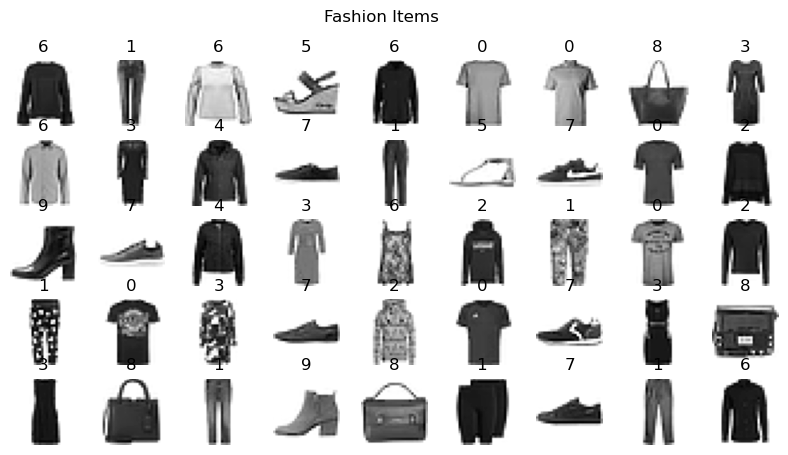

In [ ]:
# Shows some of the fashion items as random samples

fig,ax = plt.subplots(5,9,figsize = (10,5))     # Figure to contain subplots in 5-rows and 9-columns arrangement
ax = ax.ravel()                                 # Flattens the axes allowing accessing each axis contiguously
for i in range(5*9):
  rand = np.random.randint(0,len(X_train_full)) # Generate an index randomly to be used for random item selection
  image = X_train_full[rand]                    # Gets an image indexed by the random number generated in previous step
  ax[i].imshow(image, cmap = 'binary')          # Shows the image
  ax[i].set_title(y_train_full[rand])           # Sets the class of the image as title to be shown in the figure
  ax[i].axis("off")                             # Set the axis off for being non-relevant in this case

fig.suptitle("Fashion Items")                   # Sets title of the figure
fig.show()                                      # Finally, shows the figure

## Preparing Dataset

In [75]:
# Considering the datatype, values are normalized in range 0 — 1 by dividing each value by 255

X_train_full = X_train_full / 255.
X_test = X_test / 255.

In [76]:
# Separates validation set from full train set stratifically

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=10_000, random_state=42, stratify=y_train_full)

In [77]:
# Checks the shape of the splits
print("X_val Shape:", X_val.shape)
print("y_val Shape:", y_val.shape)

X_val Shape: (10000, 28, 28)
y_val Shape: (10000,)


## Modeling

### Modeling Denoising Stacked Autoencoder using Dropout

In [52]:
tf.random.set_seed(42)      # Sets the global random seed for operations that rely on a random seed

In [ ]:
# Models the stacked encoder
dropout_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),          # Flattens 2D images into 1D to send through regular dense feed-forward network
    tf.keras.layers.Dropout(0.5),       # One of the alternatives to Dropout layer is tf.keras.layers.GaussianNoise
    tf.keras.layers.Dense(100, activation="relu"),  # 100-output dense layer with ReLu activation
    tf.keras.layers.Dense(30, activation="relu")    # 30-output dense layer with ReLu activation
])

In [ ]:
# Similarly, models the mirrored stacked decoder
dropout_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])               # Converts back 1D output to 2D [considering data as images]
])

In [ ]:
# Combines both encoder and decoder as an autoencoder model
dropout_autoencoder = tf.keras.Sequential([dropout_encoder, dropout_decoder])

# Compiles the model
# NOTE: Parameter "metrics" might not be required in this case as optimization will be based on loss function provided
dropout_autoencoder.compile(loss="mse", optimizer="nadam")  

In [ ]:
# Fits the autoencoder
history = dropout_autoencoder.fit(
    
    # Both features and target will generally be same for autoencoder
    X_train, X_train,
    
    # Validation to be used for measure performance over each epoch and also for early stopping training
    validation_data=(X_val, X_val),     
    
    epochs=100, 
    
    callbacks=[
        # Early stopping callback to stop training after certrain training iterations with no performance improvement
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
        ])

Epoch 1/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0423 - val_loss: 0.0219
Epoch 2/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0231 - val_loss: 0.0203
Epoch 3/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0216 - val_loss: 0.0193
Epoch 4/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0208 - val_loss: 0.0187
Epoch 5/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0203 - val_loss: 0.0181
Epoch 6/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0198 - val_loss: 0.0179
Epoch 7/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0195 - val_loss: 0.0175
Epoch 8/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0193 - val_loss: 0.0174
Epoch 9/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0191 - val_loss: 0.0172
Epoch 10/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0189 - val_loss: 0.0170
Epoch 11/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0188 - val_loss: 0.0169
Epoch 12/100
1563/

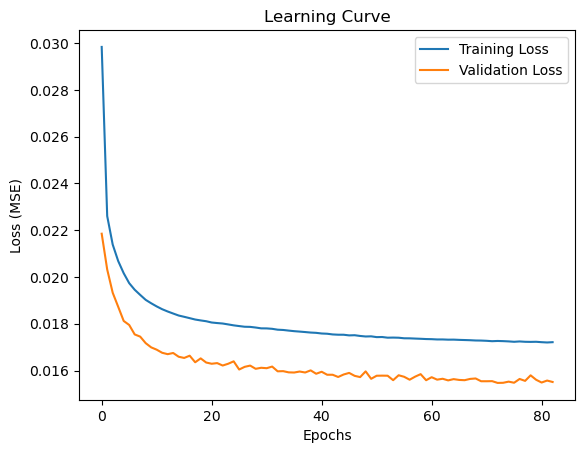

In [ ]:
# Visualizing learning curve

plt.plot(history.history["loss"], label="Training Loss")        # Plots training loss
plt.plot(history.history["val_loss"], label="Validation Loss")  # Plots validation loss
plt.xlabel("Epochs")                                            # Sets label for x-axis
plt.ylabel("Loss (MSE)")                                        # Sets label for y-axis
plt.legend()                                                    # Enables legends to be shown
plt.title("Learning Curve")                                     # Sets the title of the plot

plt.show()                                                      # Finally, shows the plot

## Visualizing Denoising Performance

In [ ]:
# Adds noise to all the images in the test set using dropout layer
X_test_noisy = tf.keras.layers.Dropout(0.5)(X_test, training=True)

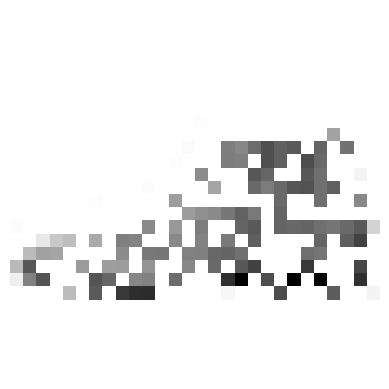

In [111]:
# [OPTIONAL] Shows just one noisy image for reference
plt.imshow(X_test_noisy[0], cmap="binary")
plt.axis("off")
plt.show()

In [ ]:
# Now, reconstructs noisy images by passing them through decoder
reconstructed_test_images = dropout_autoencoder(X_test_noisy)

/tmp/ipykernel_7575/2403933257.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


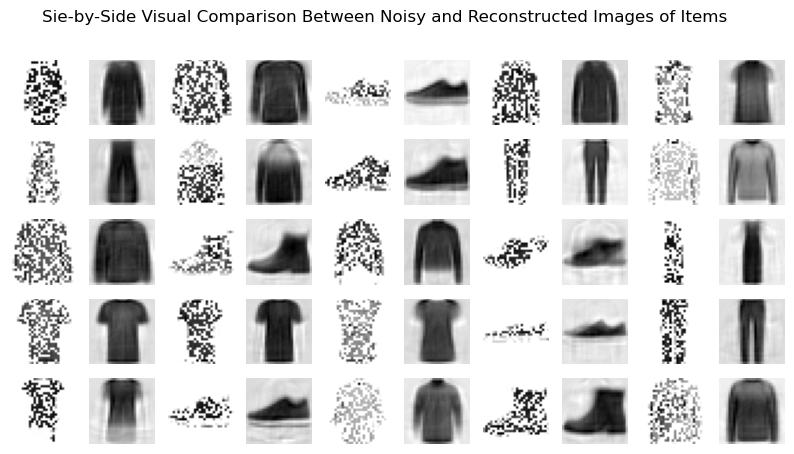

In [ ]:
# Shows some of the fashion items as random samples

fig,ax = plt.subplots(5,10,figsize = (10,5))

ax = ax.ravel()

for i in range(25):
    rand = np.random.randint(0,len(X_test))
    noisy_image = X_test_noisy[rand]
    reconstructed_image = reconstructed_test_images[rand]

    ax[i*2].imshow(noisy_image, cmap = 'binary')
    ax[i*2].axis("off")
    
    ax[i*2+1].imshow(reconstructed_image, cmap = 'binary')
    ax[i*2+1].axis("off")

fig.suptitle("Sie-by-Side Visual Comparison Between Noisy and Reconstructed Images of Items")
fig.show()